In [1]:
import torch
import triton
import triton.language as tl
from transformers.models.llama.modeling_llama import LlamaRMSNorm
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'

/sharedata/mdy/miniforge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- RMSNorm的实现，写了详细的求导过程，帮助理解
- 对比torch内置和hf-llama的

# core

### 1 RMSNorm前向传播
#### x是一个N维向量，“*” 是element-wise的乘法
$$y=RMSNorm(x) = \frac{x}{\sqrt{\sum_{i=1}^N x_i^2 + eps}} * weight$$
### 2 反向传播推导
#### $\frac{\partial L}{\partial y}$是Loss对y的导数
#### $\frac{\partial L}{\partial x}$是Loss对x的导数
#### $\frac{\partial L}{\partial w}$是L对w的导数
#### $\hat{x} = \frac{x}{\sqrt{\sum_{i=1}^N x_i^2 + eps}}$
#### $std = \sqrt{\sum_{i=1}^N x_i^2 + eps}$
### 2.1 求dw
$$
\begin{aligned}
\frac{\partial L}{\partial w_i} &= \sum_{j=1}^N \frac{\partial y_j}{\partial w_i} \frac{\partial L}{\partial y_j}\\
&= \frac{\partial y_i}{\partial w_i} \frac{\partial L}{\partial y_i}\\
&= \hat{x_{i}} \frac{\partial L}{\partial y_i}
\end{aligned}$$
#### 推广到向量表示
$$\frac{\partial L}{\partial w} = \hat{x} * \frac{\partial L}{\partial y}$$
### 2.2 求dx
$$\frac{\partial L}{\partial x_i} = \sum_{j=1}^N \frac{\partial y_j}{\partial x_i} \frac{\partial L}{\partial y_j}$$
#### 先求$\frac{\partial y_j}{\partial x_i}$, 下面根据乘法求导法则和链式法则, $I(i==j)$是示性函数,i=j为1否则为0
$$\begin{aligned}
\frac{\partial y_j}{\partial x_i} &= \frac{I(i==j)}{std}*w_j + x_j * (-\frac{1}{2})*\frac{1}{std^3}*\frac{1}{N}*2x_i *w_j\\
&= (I(i==j)*w_j -\frac{1}{N}*\hat{x_i}*\hat{x_j}*w_j)/std\\
\end{aligned}$$
### 带进去,第2行括号里改成内积形式
$$
\begin{aligned}
\frac{\partial L}{\partial x_i} &= \sum_{j=1}^N \frac{\partial y_j}{\partial x_i} \frac{\partial L}{\partial y_j}\\
&= (w_j * \frac{\partial L}{\partial y_i} -\frac{\hat{x_i}}{N}* (\sum_{j=1}^N \hat{x_j}*w_j*\frac{\partial L}{\partial y_j}))/std\\
&= (w_j * \frac{\partial L}{\partial y_i} -\frac{\hat{x_i}}{N}* (\hat{x^T}(w * \frac{\partial L}{\partial y})))/std
\end{aligned}$$
#### 推广到向量表示
$$\frac{\partial L}{\partial x} = (w * \frac{\partial L}{\partial y} -\frac{\hat{x}}{N}* (\hat{x^T}(w * \frac{\partial L}{\partial y})))/std$$

In [2]:
@triton.autotune([triton.Config({}, num_warps=nw)
                  for nw in [1, 2, 4, 8, 16]],
                  key=['BLOCK_N'])
@triton.jit
def _rmsnorm_fwd(X, Y, W, RMS_STD, eps,
                 row_stride,
                 N,
                 BLOCK_N:tl.constexpr,):
    row_id = tl.cast(tl.program_id(0), tl.int64)
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N

    x = tl.load(X + row_id * row_stride + cols, mask=mask, other=0.).to(tl.float32)
    w = tl.load(W + cols, mask=mask, other=0.).to(tl.float32)

    rms_std = tl.sqrt(tl.sum(x * x) / N + eps)
    x_hat = x / rms_std
    y = x_hat * w

    tl.store(Y + row_id * row_stride + cols, y, mask=mask)
    tl.store(RMS_STD+row_id, rms_std)

@triton.autotune([triton.Config({}, num_warps=nw)
                  for nw in [1, 2, 4, 8, 16]],
                  key=['BLOCK_N'])
@triton.jit
def _rmsnorm_bwd_dx_fused(DX, DY, DW, X, W, RMS_STD,
                        row_stride,
                        M, N, BLOCK_N:tl.constexpr):
    start_id = tl.cast(tl.program_id(0), tl.int64)
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N
    dw = tl.zeros([BLOCK_N,], dtype=tl.float32)
    for row_id in range(start_id, M, tl.num_programs(0)):
        x = tl.load(X + row_id * row_stride + cols, mask=mask, other=0.).to(tl.float32)
        w = tl.load(W + cols, mask=mask, other=0.)
        dy = tl.load(DY + row_id * row_stride + cols, mask=mask, other=0.).to(tl.float32)
        rms_std = tl.load(RMS_STD+row_id)

        x_hat = x / rms_std
        wdy = w * dy
        dx = (wdy - (x_hat / N) * tl.sum(x_hat * wdy)) / rms_std
        tl.store(DX + row_id * row_stride + cols, dx, mask=mask)

        dw += x_hat * dy
    tl.store(DW + start_id * row_stride + cols, dw, mask=mask)


class _TritronRMSNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, hidden_state, weight, eps):
        ctx.input_shape = hidden_state.shape
        output = torch.empty_like(hidden_state)
        hidden_state = hidden_state.reshape(-1, ctx.input_shape[-1])
        M,N = hidden_state.shape
        BLOCK_N = triton.next_power_of_2(N)
        rms_std = torch.empty(M, dtype=torch.float32, device=hidden_state.device)
        _rmsnorm_fwd[(M, )](hidden_state, output, weight, rms_std, eps,
                            hidden_state.stride(0),
                            N,
                            BLOCK_N,
                            )
        ctx.save_for_backward(hidden_state, weight, rms_std)
        return output
    
    @staticmethod
    def backward(ctx, dy):
        # dy = dy.contiguous()
        hidden_state, weight, rms_std = ctx.saved_tensors
        hidden_state = hidden_state.reshape(-1, hidden_state.shape[-1])
        M,N = hidden_state.shape
        BLOCK_N = triton.next_power_of_2(N)

        NUM_SMS = torch.cuda.get_device_properties('cuda').multi_processor_count
        dw = torch.empty(NUM_SMS, N, dtype=torch.float32, device=weight.device)
        dx = torch.empty_like(dy)
        
        _rmsnorm_bwd_dx_fused[(NUM_SMS,)](dx, dy, dw, hidden_state, weight, rms_std, 
                 hidden_state.stride(0),
                 M, N, BLOCK_N
                 )
        dw = dw.sum(0).to(weight.dtype)
        return dx.view(*ctx.input_shape), dw, None

triton_rmsnorm = _TritronRMSNorm.apply
class TritonRMSNorm(torch.nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.ones(hidden_size))
        self.eps = eps
    
    def forward(self, hidden_state):
        return triton_rmsnorm(hidden_state, self.weight, self.eps)

# 精度测试

In [13]:
dim = 3585
dtype = torch.bfloat16
rmsnorm_triton = TritonRMSNorm(dim, eps=1e-6).cuda().to(dtype)
rmsnorm_llama = LlamaRMSNorm(dim, eps=1e-6).cuda().to(dtype)
rmsnorm_llama.weight.data = torch.randn(dim).cuda().to(dtype)
rmsnorm_triton.weight.data.copy_(rmsnorm_llama.weight.data)
x1 = torch.randn(8192 * 2, dim).cuda().to(dtype)
x2 = torch.randn(8192 * 2, dim).cuda().to(dtype)
x2.data.copy_(x1)
x1.requires_grad = True
x2.requires_grad = True
dy = torch.ones_like(x1)


In [15]:
if x1.grad is not None:
    x1.grad.zero_()
    rmsnorm_llama.weight.grad.zero_()
y1 = rmsnorm_llama(x1)
y1.backward(dy)

if x2.grad is not None:
    x2.grad.zero_()
    rmsnorm_triton.weight.grad.zero_()
y2 = rmsnorm_triton(x2)
y2.backward(dy)


print('triton vs hf-llama')
print(torch.allclose(y1, y2, 0.0001, 0.0001), (y1 - y2).abs().max().item())
print(torch.allclose(x1.grad, x2.grad, 0.0001, 0.0001), (x1.grad - x2.grad).abs().max().item())
print(torch.allclose(rmsnorm_llama.weight.grad, rmsnorm_triton.weight.grad, 0.0001, 0.0001),
      (rmsnorm_llama.weight.grad - rmsnorm_triton.weight.grad).abs().max().item())


triton vs hf-llama
False 0.0625
False 0.015625
False 2.0


# Forward benchmark

bs: 8, seq_len: 1024
Triton autotuning for function _rmsnorm_fwd finished after 1.02s; best config selected: num_warps: 2, num_ctas: 1, num_stages: 2, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 1.09s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 1.27s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 1.75s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None;
Triton autotuning for function 

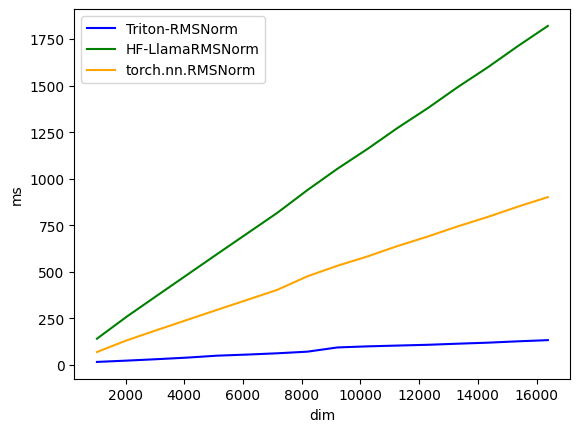

RMSNorm:
        dim  Triton-RMSNorm  HF-LlamaRMSNorm  torch.nn.RMSNorm
0    1024.0       15.973479       140.719354         69.278598
1    2048.0       23.050833       260.161459        132.337272
2    3072.0       30.750984       372.297883        187.396333
3    4096.0       39.101072       483.878046        241.677880
4    5120.0       49.609777       595.513463        295.899093
5    6144.0       55.496704       706.142485        349.312544
6    7168.0       62.357385       816.811919        403.124720
7    8192.0       71.044594       938.829303        475.697428
8    9216.0       93.727320      1053.509593        532.463908
9   10240.0       99.560834      1159.850717        582.645059
10  11264.0      103.839926      1272.749543        638.487220
11  12288.0      107.983924      1378.393769        689.254224
12  13312.0      113.869652      1491.793633        743.923187
13  14336.0      119.349420      1598.220587        794.704378
14  15360.0      126.597047      1712.006450  

In [6]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-RMSNorm', 'HF-LlamaRMSNorm', 'torch.nn.RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-RMSNorm",
            "HF-LlamaRMSNorm",
            "torch.nn.RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'HF-LlamaRMSNorm':
        rmsnorm_llama = LlamaRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_llama(tensor))
    if provider == 'Triton-RMSNorm':
        rmsnorm_triton = TritonRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_triton(tensor))
    if provider == 'torch.nn.RMSNorm':
        rmsnorm_triton = torch.nn.RMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_triton(tensor))

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# Backward benchmark

bs: 8, seq_len: 1024
Triton autotuning for function _rmsnorm_fwd finished after 0.62s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_bwd_dx_fused finished after 0.60s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 0.58s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_bwd_dx_fused finished after 0.60s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 0.59s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_bwd_dx_fused finished after 0.62s; best config selected: num_warps: 16, num_ctas: 1, num_stages: 2, maxnreg: None;
Triton autotuning for function _rmsnorm_fwd finished after 0.60s; best config sel

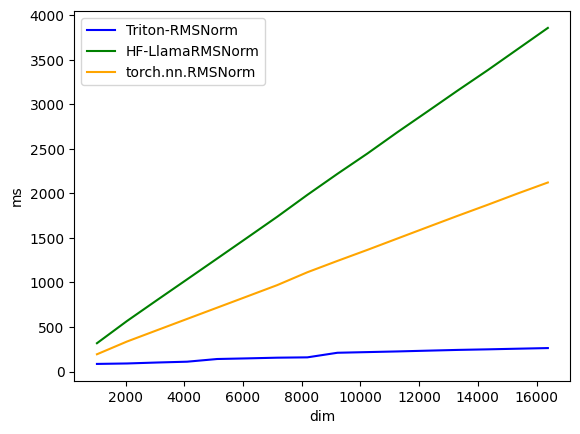

RMSNorm:
        dim  Triton-RMSNorm  HF-LlamaRMSNorm  torch.nn.RMSNorm
0    1024.0       85.625067       318.088442        193.955302
1    2048.0       90.717226       567.630470        337.140858
2    3072.0      101.451367       802.493334        464.212447
3    4096.0      110.647194      1035.443187        590.929806
4    5120.0      140.789628      1268.996954        717.392206
5    6144.0      147.875950      1503.264666        843.998432
6    7168.0      155.686468      1738.743424        970.858216
7    8192.0      159.418300      1983.961701       1114.919901
8    9216.0      210.956857      2219.896317       1242.234945
9   10240.0      218.391374      2448.610783       1366.470575
10  11264.0      225.862399      2688.612938       1494.191885
11  12288.0      234.557763      2920.977592       1621.744514
12  13312.0      242.942020      3155.173779       1748.531938
13  14336.0      249.332204      3384.104013       1872.486711
14  15360.0      256.566614      3621.147871  

In [16]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-RMSNorm', 'HF-LlamaRMSNorm', 'torch.nn.RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-RMSNorm",
            "HF-LlamaRMSNorm",
            "torch.nn.RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    dy = torch.ones_like(tensor)
    if provider == 'HF-LlamaRMSNorm':
        rmsnorm_llama = LlamaRMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_llama(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])

    if provider == 'Triton-RMSNorm':
        rmsnorm_triton = TritonRMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_triton(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])
    
    if provider == 'torch.nn.RMSNorm':
        rmsnorm_triton = torch.nn.RMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_triton(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])
    

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


In [14]:
torch.nn.RMSNorm(5)

RMSNorm((5,), eps=None, elementwise_affine=True)